### Class 7- solution

In [33]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
%pylab inline
import seaborn as sn

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


###Create sample data and fit a model

In [29]:
# np.random.seed(10)

df = pd.DataFrame({'x': range(100), 'y': range(100)})
# NOTE: Whenever you make changes to dataframes and want to keep the original
# make sure you do a deep copy
biased_df  = df.copy(deep=True) 
biased_df.loc[:20, 'x'] = 1 # create a bias with both columns

def append_jitter(series):
    # adds uniform random variable to the input series
    jitter = np.random.random_sample(size=series.shape[0])
    return series + jitter

df['x'] = append_jitter(df.x)
df['y'] = append_jitter(df.y)

biased_df['x'] = append_jitter(biased_df.x)
biased_df['y'] = append_jitter(biased_df.y)


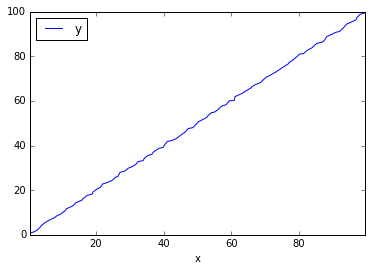

In [30]:
df.plot(x='x',y='y')

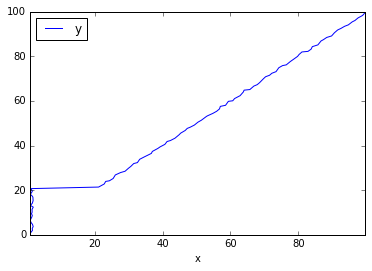

In [31]:
biased_df.plot(x='x',y='y')

In [40]:
## fit
lm = linear_model.LinearRegression().fit(df[['x']], df['y'])
print metrics.mean_squared_error(df['y'], lm.predict(df[['x']]))


0.147247249497


In [41]:
## biased fit
lm_biased = linear_model.LinearRegression().fit(biased_df[['x']], biased_df['y'])
print metrics.mean_squared_error(df['y'], lm_biased.predict(df[['x']]))

10.0043676262


### Question - Try to plot out the best fit line based on the model prediction using the input X vector.

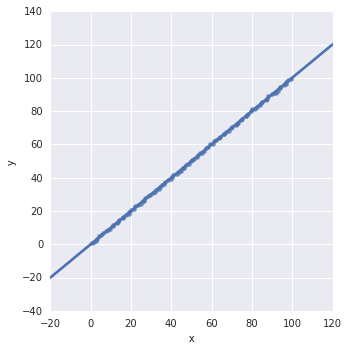

In [35]:
sn.lmplot('x','y',df)

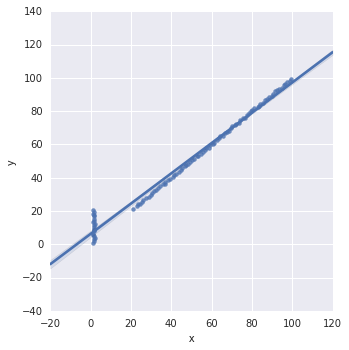

In [36]:
sn.lmplot('x','y',biased_df)

## Bonus - try to look at the distribution of the residuals

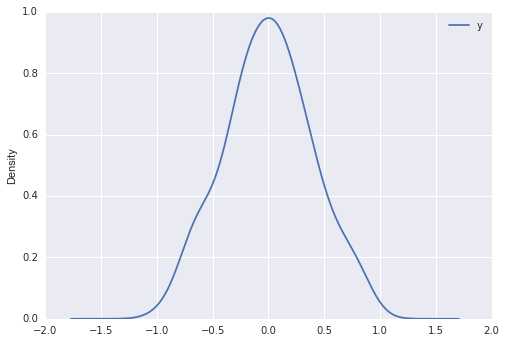

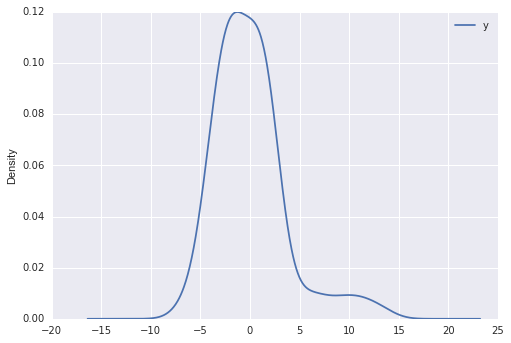

In [42]:
pd.DataFrame(df['y']- lm.predict(df[['x']])).plot(kind='density')
pd.DataFrame(biased_df['y']- lm_biased.predict(biased_df[['x']])).plot(kind='density')

## Cross validation
#### Intro to cross validation with bike share data from last time. We will be modeling casual ridership. 

In [43]:
from sklearn import cross_validation
wd = '../../assets/dataset/'
bikeshare = pd.read_csv(wd + 'bikeshare.csv')

####Create dummy variables and set outcome (dependent) variable

In [44]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual 

#### Create a cross valiation with 5 folds

In [45]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)

In [46]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1638.60328517
R2: 0.311918594619
Model 2
MSE: 1716.86047618
R2: 0.311892653587
Model 3
MSE: 1859.94391974
R2: 0.311875827015
Model 4
MSE: 1573.03874014
R2: 0.311879032906
Model 5
MSE: 1580.05672864
R2: 0.311849988514
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1673.70062997
Mean of R2 for all folds: 0.311883219328


In [47]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print "~~~~ Single Model ~~~~"
print 'MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'R2: ', lm.score(modeldata, y)

~~~~ Single Model ~~~~
MSE of single model: 1672.58110765
R2:  0.311934605989


### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


Answer: this score will be lower with the single model in the case, but we're trading off bias error for generalized error

###Advanced: There are ways to improve our model with regularization. 
Let's check out the effects on MSE and R2

In [48]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'OLS R2:', lm.score(modeldata, y)

lm = linear_model.Lasso().fit(modeldata, y)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'Lasso R2:', lm.score(modeldata, y)

lm = linear_model.Ridge().fit(modeldata, y)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(y, lm.predict(modeldata))
print 'Ridge R2:', lm.score(modeldata, y)

~~~ OLS ~~~
OLS MSE:  1672.58110765
OLS R2: 0.311934605989
~~~ Lasso ~~~
Lasso MSE:  1725.41581608
Lasso R2: 0.290199495922
~~~ Ridge ~~~
Ridge MSE:  1672.60490113
Ridge R2: 0.311924817843


### Figuring out the alphas can be done by "hand"

In [49]:
alphas = np.logspace(-10, 10, 21)
for a in alphas:
    print 'Alpha:', a
    lm = linear_model.Ridge(alpha=a)
    lm.fit(modeldata, y)
    print lm.coef_
    print metrics.mean_squared_error(y, lm.predict(modeldata))

Alpha: 1e-10
[ 112.68901765  -84.01121684  -24.68489063  -21.00314493  -21.71893628]
1672.58110765
Alpha: 1e-09
[ 112.68901765  -84.01121684  -24.68489061  -21.00314491  -21.71893626]
1672.58110765
Alpha: 1e-08
[ 112.68901765  -84.01121684  -24.6848904   -21.00314471  -21.71893606]
1672.58110765
Alpha: 1e-07
[ 112.68901763  -84.01121682  -24.68488837  -21.00314268  -21.71893403]
1672.58110765
Alpha: 1e-06
[ 112.68901745  -84.01121667  -24.68486804  -21.00312237  -21.71891373]
1672.58110765
Alpha: 1e-05
[ 112.68901562  -84.01121509  -24.68466472  -21.00291929  -21.71871079]
1672.58110765
Alpha: 0.0001
[ 112.68899732  -84.01119938  -24.68263174  -21.00088873  -21.71668162]
1672.58110765
Alpha: 0.001
[ 112.68881437  -84.01104228  -24.66232204  -20.98060316  -21.69640993]
1672.58110774
Alpha: 0.01
[ 112.68698753  -84.00947323  -24.46121539  -20.77973778  -21.49568404]
1672.58111645
Alpha: 0.1
[ 112.66896732  -83.99396383  -22.63109556  -18.95202277  -19.66942371]
1672.58185208
Alpha: 1.0
[

### Or we can use grid search to make this faster

In [13]:
from sklearn import grid_search

alphas = np.logspace(-10, 10, 21)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(modeldata, y)


/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in vers

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

##### Best score 

In [14]:
print gs.best_score_ 

-1814.09369133


##### mean squared error here comes in negative, so let's make it positive.

In [15]:
print -gs.best_score_ 

1814.09369133


##### explains which grid_search setup worked best

In [16]:
print gs.best_estimator_ 

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


##### shows all the grid pairings and their performances.

In [17]:
print gs.grid_scores_ 

[mean: -1817.58711, std: 542.14315, params: {'alpha': 1e-10}, mean: -1817.58711, std: 542.14315, params: {'alpha': 1.0000000000000001e-09}, mean: -1817.58711, std: 542.14315, params: {'alpha': 1e-08}, mean: -1817.58711, std: 542.14315, params: {'alpha': 9.9999999999999995e-08}, mean: -1817.58711, std: 542.14315, params: {'alpha': 9.9999999999999995e-07}, mean: -1817.58711, std: 542.14317, params: {'alpha': 1.0000000000000001e-05}, mean: -1817.58707, std: 542.14331, params: {'alpha': 0.0001}, mean: -1817.58663, std: 542.14477, params: {'alpha': 0.001}, mean: -1817.58230, std: 542.15933, params: {'alpha': 0.01}, mean: -1817.54318, std: 542.30102, params: {'alpha': 0.10000000000000001}, mean: -1817.20111, std: 543.63587, params: {'alpha': 1.0}, mean: -1814.09369, std: 556.35563, params: {'alpha': 10.0}, mean: -1818.51694, std: 653.68607, params: {'alpha': 100.0}, mean: -2125.58777, std: 872.45270, params: {'alpha': 1000.0}, mean: -2458.08836, std: 951.30428, params: {'alpha': 10000.0}, me

#Independent Practice: Bike data revisited

There are tons of ways to approach a regression problem. The regularization techniques appended to ordinary least squares optimizes the size of coefficients to best account for error. Gradient Descent also introduces learning rate (how aggressively do we solve the problem), epsilon (at what point do we say the error margin is acceptable), and iterations (when should we stop no matter what?)

For this deliverable, our goals are to:

- implement the gradient descent/OLS/ridge/Lasso approach to our bike-share modeling problem,
- demonstrate the grid_search module!

While exploring the Gradient Descent regressor object, you'll build a grid search using the stochastic gradient descent estimator for the bike-share data set. Continue with either the model you evaluated last class or the simpler one from today. In particular, be sure to implement the "param_grid" in the grid search to get answers for the following questions:

- With a set of alpha values between 10^-10 and 10^-1, how does the mean squared error change?
- Based on the data, we know when to properly use l1 vs l2 regularization. By using a grid search with l1_ratios between 0 and 1 (increasing every 0.05), does that statement hold true? If not, did gradient descent have enough iterations?
- How do these results change when you alter the learning rate (eta0)?

**Bonus**: Can you see the advantages and disadvantages of using gradient descent after finishing this exercise?

### Starter Code

In [18]:
params = {} # put your gradient descent parameters here
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )

gs.fit(modeldata, y)

print 'BEST ESTIMATOR'
print -gs.best_score_
print gs.best_estimator_
print 'ALL ESTIMATORS'
print gs.grid_scores_

BEST ESTIMATOR
1688.23536973
SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)
ALL ESTIMATORS
[mean: -1688.23537, std: 49.72996, params: {}]


/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight

### Independent Practice Solution

This code shows the variety of challenges and some student gotchas. The plots will help showcase what should be learned.

1. With a set of alpha values between 10^-10 and 10^-1, how does the mean squared error change?
2. We know when to properly use l1 vs l2 regularization based on the data. By using a grid search with l1_ratios between 0 and 1 (increasing every 0.05), does that statement hold true?
    * (if it didn't look like it, did gradient descent have enough iterations?)
3. How do results change when you alter the learning rate (power_t)?

In [19]:
%matplotlib inline

In [56]:
alphas = np.logspace(-10, -1, 10)
print alphas
params = {'alpha':alphas, } # put your gradient descent parameters here
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )

gs.fit(modeldata, y)
    

[  1.00000000e-10   1.00000000e-09   1.00000000e-08   1.00000000e-07
   1.00000000e-06   1.00000000e-05   1.00000000e-04   1.00000000e-03
   1.00000000e-02   1.00000000e-01]


/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/srikanajan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight

GridSearchCV(cv=sklearn.cross_validation.KFold(n=17379, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [68]:
grid = pd.DataFrame(gs.grid_scores_)
grid.parameters = grid.parameters.apply(lambda x: x['alpha'])
grid.mean_validation_score = grid.mean_validation_score.apply(lambda x: -x)
grid.columns = ['alpha', 'mean_squared_error', 'cv']

In [70]:
grid

,alpha,mean_squared_error,cv
0,1.000000e-10,1688.905819,"[-1581.01016374, -1729.59281896, -1623.3894756..."
1,1.000000e-09,1687.916253,"[-1577.65380707, -1729.6317642, -1623.24538624..."
2,1.000000e-08,1689.134147,"[-1578.27953874, -1730.77340157, -1624.3944061..."
3,1.000000e-07,1691.142410,"[-1579.79345468, -1732.98186364, -1623.7659517..."
4,1.000000e-06,1689.653692,"[-1580.71069605, -1729.99624749, -1622.9871074..."
5,1.000000e-05,1688.918809,"[-1578.4436487, -1729.61068882, -1626.22637777..."
6,1.000000e-04,1690.182287,"[-1577.55083465, -1738.63275829, -1623.7223272..."
7,1.000000e-03,1691.841704,"[-1581.55404824, -1734.13441177, -1627.1271378..."
8,1.000000e-02,1730.040104,"[-1607.08183342, -1777.83949166, -1667.3025877..."
9,1.000000e-01,2051.903137,"[-1896.85834354, -2114.6558832, -1998.46066996..."


With the alphas available, it looks like at mean squared error stays generally flat with incredibly small alpha values, but starting at $10^{-3}$, the error begins to elbow. We probably don't have much of a different in performance with other alpha values. 

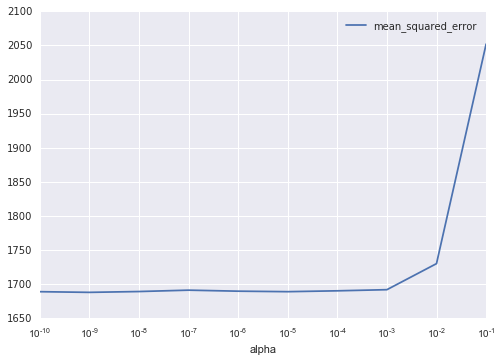

In [72]:
grid.plot('alpha', 'mean_squared_error', logx=True)

At alpha values of either .1 or 1, the l1_ratio works best closer to 1! Interesting. At other values of alpha they should see similar results, though the graphs aren't as clear.

In [85]:
l1_2_ratios = [float(i) / 100 for i in range(0, 101, 5)]
print l1_2_ratios
params = {'l1_ratio':l1_2_ratios, 'penalty': ['elasticnet'], 'alpha': [.1], 'n_iter': [50]}
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='neg_mean_squared_error',
    )

gs.fit(modeldata, y)

grid = pd.DataFrame(gs.grid_scores_)
grid.parameters = grid.parameters.apply(lambda x: x['l1_ratio'])
grid.mean_validation_score = grid.mean_validation_score.apply(lambda x: -x)
grid.columns = ['l1_ratio', 'neg_mean_squared_error', 'cv']
    

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


In [86]:
gs.best_estimator_

SGDRegressor(alpha=0.1, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=1.0, learning_rate='invscaling',
       loss='squared_loss', n_iter=50, penalty='elasticnet', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

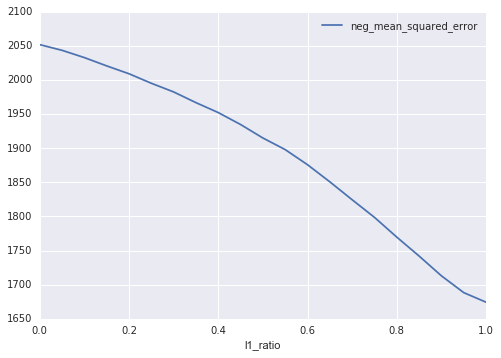

In [87]:
grid.plot('l1_ratio', 'neg_mean_squared_error')

In [92]:
learning = range(1, 50)
print learning
params = {'eta0':learning, 'n_iter': [50]}
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='neg_mean_squared_error',
    )

gs.fit(modeldata, y)

grid = pd.DataFrame(gs.grid_scores_)
grid.parameters = grid.parameters.apply(lambda x: x['eta0'])
grid.mean_validation_score = grid.mean_validation_score.apply(lambda x: -x)
grid.columns = ['eta0', 'neg_mean_squared_error', 'cv']
    
    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


Here it should be apparent that as the initial learning rate increases, the error should _also_ increase. And what happens when the initial learning rate is too high? A dramatic increase in error. Students should recognize the importance of learning rate and what values it should be set at, the smaller generally the better.

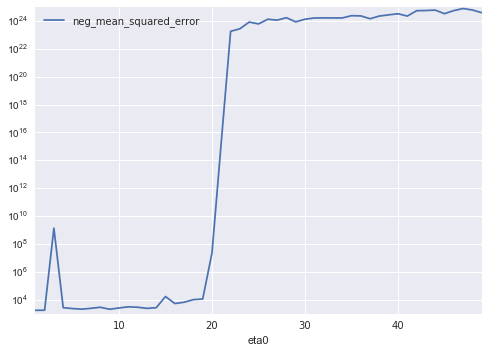

In [93]:
grid.plot('eta0', 'neg_mean_squared_error', logy=True)